[data set from kaggle](https://www.kaggle.com/tmdb/tmdb-movie-metadata#tmdb_5000_movies.csv)

### Data Overview
* 2 files - 1 with full cast and crew credits other has movie metadata around the relase, language, popularity etc.
* file 1: credits
    * 4 columns, 4800 movies
    * 1 json of crew id/name/job and 1 json of cast character/actor/gender/id
* file 2: movie metadata
    * continuous variables: release_date, revenue, runtime, vote average (1-10), vote_count
    * categorical variables: genre (json needs parsing), keywords (thems like 'space war' also json), original language (mostly english), plot overview, production company, production_countries, 

# Scaling 
* StandardScaler -> features with a mean=0 and variance=1
* MinMaxScaler -> features in a 0 to 1 range
* Normalizer -> feature vector to a Euclidean length=1

In [228]:
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.io.json import json_normalize
import json

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
import datetime
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
def json_decode(data):
    movie_id_list = []
    credit_id_list = []
    department_list = []
    job_list = []    

    for n in np.arange(len(data)):
        json_cell = json.loads(data['crew'][n]) #convert to jsonjsonn from string
        for item in json_cell: #convert to list from json
            movie_id_list.append(data['movie_id'][n])
            credit_id_list.append(str(item['credit_id']))
            department_list.append(str(item['department']))
            job_list.append(str(item['job']))
        
    result = pd.DataFrame(data={'movie_id':movie_id_list,
                                'department':department_list,
                                'credit_id':credit_id_list,
                                'job':job_list})
                                   
    return result

In [175]:
def json_parse(data, column_name):
    universal_id_list = []
    column_name_list = []
    
    
    for n in np.arange(len(data)):
        json_cell = json.loads(data[column_name][n])
        for item in json_cell:
            universal_id_list.append(data['movie_id'][n])
            column_name_list.append(str(item['name']))
    df_parsed = pd.DataFrame(data={'movie_id':universal_id_list,
                                str(column_name):column_name_list})
    total_column_name = 'total_'+str(column_name)
    df_parsed[total_column_name] = 1
    total_columns = df_parsed.groupby('movie_id').sum()[total_column_name]
    df_parsed = df_parsed.pivot_table(index=['movie_id'], 
                                      columns=[column_name],  
                                      fill_value=0)[total_column_name]
    result = df_parsed.join(total_columns, on='movie_id', how='inner')
    return result
        

In [229]:
df_movies = pd.DataFrame(pd.read_csv('tmdb/tmdb_5000_movies.csv'))
df_movies = df_movies.rename(columns={'id':'movie_id'})
#df_movies = df_movies[df_movies['release_date']>='2010-01-01']

In [235]:
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'])
df_movies['month']=df_movies['release_date'].apply(lambda x: x.month)
df_movies['year']=df_movies['release_date'].apply(lambda x: x.year)
df_movies['random_number'] = np.random.rand(len(df_movies['vote_average']),1)
df_movies = df_movies.sort_values(by='random_number')

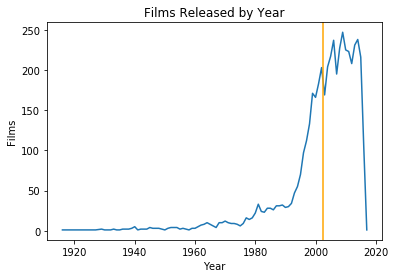

In [285]:
plt.plot(df_movies.groupby('year').count().sort_values(by='year')['movie_id'], label='Number of Films')
plt.axvline(x=df_movies['year'].mean(), c='orange', label='')
plt.xlabel('Year')
plt.ylabel('Films')
plt.title('Films Released by Year')
plt.show()

In [198]:
production_features.head()

,1.85 Films,100 Bares,1019 Entertainment,10th Hole Productions,120dB Films,1492 Pictures,1812 Productions,1821 Pictures,1984 Private Defense Contractors,20th Century Fox Russia,...,Zippcast Films,Zookeeper Productions,bob industries,nWave Pictures,platinum studios,thefyzz,uFilm,unafilm,warner bross Turkey,total_production_companies
movie_id,,,,,,,,,,,,,,,,,,,,,
189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1771,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1865,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [262]:
df_movies[df_movies[['budget','movie_id', 'runtime', 'vote_average']].isnull().any(axis=1)] #df[df.isnull().any(axis=1)]

,budget,genres,homepage,movie_id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,month,year
2656,15000000,"[{""id"": 18, ""name"": ""Drama""}]",NaN,370980,"[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",it,Chiamatemi Francesco - Il Papa della gente,NaN,0.738646,"[{""name"": ""Taodue Film"", ""id"": 45724}]",...,0,NaN,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,NaN,Chiamatemi Francesco - Il Papa della gente,7.3,12,12.0,2015.0
4140,2,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,459488,"[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",en,"To Be Frank, Sinatra at 100",NaN,0.050625,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]",...,0,NaN,[],Released,NaN,"To Be Frank, Sinatra at 100",0.0,0,12.0,2015.0


In [221]:
df_movies = pd.DataFrame(pd.read_csv('tmdb/tmdb_5000_movies.csv'))
df_movies = df_movies.rename(columns={'id':'movie_id'})
df_movies = df_movies[df_movies['release_date']>='2000-01-01']
df_movies = df_movies[df_movies['budget']>0].reset_index(drop=True)
df_movies = df_movies[df_movies['runtime']>0].reset_index(drop=True)

#movie_parsed = json_movie(df_movies)
# producgion features
production_features = json_parse(df_movies, 'production_companies')
top_20 = production_features.describe().iloc[1,:].sort_values(ascending=False).head(20)
top_20 = top_20.reset_index().iloc[:,0]
production_features = production_features[top_20]

# genre features
genre_features = json_parse(df_movies, 'genres')

# join everything
df_movies = df_movies[['movie_id','budget', 'runtime', 'vote_average']]
df_movies = df_movies.set_index('movie_id').join(
    production_features, on='movie_id', how='inner').join(
    genre_features, on='movie_id', how='inner')

# Shuffle Dataset for cross val
# Shuffle Dataset
df_movies['random_number'] = np.random.rand(len(df_movies['vote_average']),1)
df_movies = df_movies.sort_values(by='random_number')

In [50]:
# import credits file
df_credits = pd.DataFrame(pd.read_csv('tmdb/tmdb_5000_credits.csv'))

# import movie file
df_movies = pd.DataFrame(pd.read_csv('tmdb/tmdb_5000_movies.csv'))
df_movies = df_movies.rename(columns={'id':'movie_id'})
df_movies = df_movies[df_movies['release_date']>='2010-01-01']
df_movies = df_movies[['movie_id','title','release_date','runtime','budget','revenue', 
                       'popularity','vote_average', 'vote_count']]

# Shuffle Dataset
df_movies = df_movies[df_movies['runtime']>0]
df_movies['random_number'] = np.random.rand(len(df_movies['movie_id']),1)
df_movies = df_movies.sort_values(by='random_number').set_index(['movie_id'])

# parse credits file
df_parsed = json_decode(df_credits)

In [51]:
# calculate pivot parsed jobs and count

job_count = df_parsed.pivot_table(index=['movie_id'], 
                                  columns=['job'], 
                                  aggfunc='count', 
                                  fill_value=0)['credit_id']

job_count = df_movies.join(job_count, on='movie_id', how='inner')

job_count['random_number'] = np.random.rand(len(job_count['title']),1)
job_count = job_count.sort_values(by='random_number')

In [52]:
department_count = df_parsed.pivot_table(index=['movie_id'], 
                                  columns=['department'], 
                                  aggfunc='count', 
                                  fill_value=0)['credit_id']

department_count = df_movies.join(department_count, on='movie_id', how='inner')

department_count['random_number'] = np.random.rand(len(department_count.iloc[:,1]),1)
department_count = department_count.sort_values(by='random_number')

In [223]:

X = df_movies.drop(columns=['vote_average', 'random_number'])
y = df_movies['vote_average']
y = y.astype('int')

# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', StandardScaler()), 
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 170, 10), # 1- 200
                                                           'max_depth': np.arange(2, 6, 1)}, 
                                               cv=3,
                                               scoring='neg_mean_squared_error',
                                               refit=False))])

pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.00001, 1.0, 0.01)},
                                             cv=3,
                                             scoring='neg_mean_squared_error',
                                             refit=False))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 3, .2)},
                                             cv=3,
                                             scoring='neg_mean_squared_error',
                                             refit=False))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           ('pca', PCA(n_components=4)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(0.5, 8.0, .5)},
                                             cv=3,
                                             scoring='neg_mean_squared_error',
                                             refit=False))])
# List of pipelines for ease of iteration
pipelines = [pipe_forest, pipe_lasso, pipe_ridge, pipe_svm]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Random Forest', 1: 'Lasso Penalty', 2: 'Ridge Penalty', 3: 'SVM'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X, y)

# Compare accuracies
for idx, grid in enumerate(pipelines):
    print('%s pipeline CV Negative Mean Square Error: %.3f with parameters: %s' % (pipe_dict[idx], 
                                                                   grid.named_steps['grid'].best_score_, 
                                                                   grid.named_steps['grid'].best_params_))

# Identify the most accurate model on test data
best_neg_mean_squared_error = 0.0
best_regression = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.named_steps['grid'].best_score_ > best_neg_mean_squared_error:
        best_neg_mean_squared_error = val.named_steps['grid'].best_score_
        best_pipe = grid
        best_regression = idx
print('Regressor with best negative mean squared error: %s' % pipe_dict[best_regression])

# Save pipeline to file
#joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
#print('Saved %s pipeline to file' % pipe_dict[best_regression])

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Random Forest pipeline CV Negative Mean Square Error: -0.801 with parameters: {'max_depth': 5, 'n_estimators': 140}
Lasso Penalty pipeline CV Negative Mean Square Error: -0.827 with parameters: {'alpha': 1e-05}
Ridge Penalty pipeline CV Negative Mean Square Error: -0.827 with parameters: {'alpha': 0.01}
SVM pipeline CV Negative Mean Square Error: -0.884 with parameters: {'C': 0.5}
Regressor with best negative mean squared error: Random Forest


In [226]:

X = df_movies.drop(columns=['vote_average', 'random_number'])
y = df_movies['vote_average']
y = y.astype('int')

# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 200, 10), # 1- 200
                                                           'max_depth': np.arange(2, 6, 1)}, 
                                               cv=3,
                                               scoring='r2',
                                               refit=True))])

pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.00001, 1.0, 0.01)},
                                             cv=3,
                                             scoring='r2',
                                             refit=True))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 3, .2)},
                                             cv=3,
                                             scoring='r2',
                                             refit=True))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           ('pca', PCA(n_components=4)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(0.5, 8.0, .5)},
                                             cv=3,
                                             scoring='r2',
                                             refit=True))])
# List of pipelines for ease of iteration
pipelines = [pipe_forest]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Random Forest', 1: 'Lasso Penalty', 2: 'Ridge Penalty', 3: 'SVM'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X, y)

# Compare accuracies
for idx, grid in enumerate(pipelines):
    print('%s pipeline CV Negative Mean Square Error: %.3f with parameters: %s' % (pipe_dict[idx], 
                                                                   grid.named_steps['grid'].best_score_, 
                                                                   grid.named_steps['grid'].best_params_))

# Identify the most accurate model on test data
best_neg_mean_squared_error = 0.0
best_regression = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.named_steps['grid'].best_score_ > best_neg_mean_squared_error:
        best_neg_mean_squared_error = val.named_steps['grid'].best_score_
        best_pipe = grid
        best_regression = idx
print('Regressor with best negative mean squared error: %s' % pipe_dict[best_regression])

# Save pipeline to file
#joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
#print('Saved %s pipeline to file' % pipe_dict[best_regression])

Random Forest pipeline CV Negative Mean Square Error: 0.178 with parameters: {'max_depth': 5, 'n_estimators': 190}
Regressor with best negative mean squared error: Random Forest


In [227]:
features = pd.DataFrame(data={'features':X.columns, 
                              'feature_importance':pipe_forest.named_steps['grid'].best_estimator_.feature_importances_})
features.sort_values(by='feature_importance', ascending=False)

,features,feature_importance
1,runtime,0.467145
0,budget,0.194853
28,Drama,0.070899
2,total_production_companies,0.047636
24,Animation,0.033918
27,Documentary,0.026527
42,total_genres,0.026108
33,Horror,0.020431
22,Action,0.016368
26,Crime,0.012474


# Department Scaled Through Features

In [43]:
feature_columns = df_parsed.department.unique()

X = department_count[feature_columns]
y = department_count['vote_average']
y = y.astype('int')

# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', StandardScaler()), 
                         ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 170, 10), # 1- 200
                                                           'max_depth': np.arange(2, 6, 1)}, 
                                               cv=3,
                                               scoring='neg_mean_squared_error',
                                               refit=False))])

pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.00001, 1.0, 0.01)},
                                             cv=3,
                                             scoring='neg_mean_squared_error',
                                             refit=False))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 3, .2)},
                                             cv=3,
                                             scoring='neg_mean_squared_error',
                                             refit=False))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           ('pca', PCA(n_components=4)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(0.5, 8.0, .5)},
                                             cv=3,
                                             scoring='neg_mean_squared_error',
                                             refit=False))])
# List of pipelines for ease of iteration
pipelines = [pipe_forest, pipe_lasso, pipe_ridge, pipe_svm]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Random Forest', 1: 'Lasso Penalty', 2: 'Ridge Penalty', 3: 'SVM'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X, y)

# Compare accuracies
for idx, grid in enumerate(pipelines):
    print('%s pipeline CV Negative Mean Square Error: %.3f with parameters: %s' % (pipe_dict[idx], 
                                                                   grid.named_steps['grid'].best_score_, 
                                                                   grid.named_steps['grid'].best_params_))

# Identify the most accurate model on test data
best_neg_mean_squared_error = 0.0
best_regression = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.named_steps['grid'].best_score_ > best_neg_mean_squared_error:
        best_neg_mean_squared_error = val.named_steps['grid'].best_score_
        best_pipe = grid
        best_regression = idx
print('Regressor with best negative mean squared error: %s' % pipe_dict[best_regression])

# Save pipeline to file
#joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
#print('Saved %s pipeline to file' % pipe_dict[best_regression])

Random Forest pipeline CV Negative Mean Square Error: -1.607 with parameters: {'max_depth': 3, 'n_estimators': 130}
Lasso Penalty pipeline CV Negative Mean Square Error: -8.684 with parameters: {'alpha': 0.01001}
Ridge Penalty pipeline CV Negative Mean Square Error: -8.623 with parameters: {'alpha': 0.81}
SVM pipeline CV Negative Mean Square Error: -1.628 with parameters: {'C': 2.0}
Regressor with best negative mean squared error: Random Forest


In [40]:
feature_columns = df_parsed.department.unique()

X = department_count[feature_columns]
y = department_count['vote_average']
y = y.astype('int')

# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', MinMaxScaler()), 
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 150, 5), # 1- 200
                                                           'max_depth': np.arange(1, 6, 1)}, 
                                               cv=3,
                                               scoring='r2',
                                               refit=False))])

pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.01, 1.0, 0.2)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 2, .2)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           #('pca', PCA(n_components=5)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(8, 18, 2)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])


# List of pipelines for ease of iteration
pipelines = [pipe_forest, pipe_lasso, pipe_ridge, pipe_svm]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Random Forest', 1: 'Lasso Penalty', 2: 'Ridge Penalty', 3: 'SVM'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X, y)

# Compare accuracies
for idx, grid in enumerate(pipelines):
    print('%s pipeline test R-square: %.3f with parameters: %s' % (pipe_dict[idx], 
                                                                   grid.named_steps['grid'].best_score_, 
                                                                   grid.named_steps['grid'].best_params_))

# Identify the most accurate model on test data
best_rsquared = 0.0
best_regression = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.named_steps['grid'].best_score_ > best_rsquared:
        best_rsquared = val.named_steps['grid'].best_score_
        best_pipe = grid
        best_regression = idx
print('Regressor with best r squared: %s' % pipe_dict[best_regression])

# Save pipeline to file
#joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
#print('Saved %s pipeline to file' % pipe_dict[best_regression])

Random Forest pipeline test R-square: 0.092 with parameters: {'max_depth': 3, 'n_estimators': 140}
Lasso Penalty pipeline test R-square: -3.937 with parameters: {'alpha': 0.01}
Ridge Penalty pipeline test R-square: -3.908 with parameters: {'alpha': 0.81}
SVM pipeline test R-square: 0.081 with parameters: {'C': 14}
Regressor with best r squared: Random Forest


# Job Scaled through Features

In [44]:
feature_columns = df_parsed.job.unique()

X = job_count[feature_columns]
y = job_count['vote_average']
y = y.astype('int')

# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', MinMaxScaler()), 
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 150, 5), # 1- 200
                                                           'max_depth': np.arange(3, 6, 1)}, 
                                               cv=3,
                                               scoring='r2',
                                               refit=False))])

pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.01, 1.0, 0.2)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 2, .2)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           ('pca', PCA(n_components=20)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(8, 20, 2)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])


# List of pipelines for ease of iteration
pipelines = [pipe_forest, pipe_lasso, pipe_ridge, pipe_svm]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Random Forest', 1: 'Lasso Penalty', 2: 'Ridge Penalty', 3: 'SVM'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X, y)

# Compare accuracies
for idx, grid in enumerate(pipelines):
    print('%s pipeline test R-square: %.3f with parameters: %s' % (pipe_dict[idx], 
                                                                   grid.named_steps['grid'].best_score_, 
                                                                   grid.named_steps['grid'].best_params_))

# Identify the most accurate model on test data
best_rsquared = 0.0
best_regression = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.named_steps['grid'].best_score_ > best_rsquared:
        best_rsquared = val.named_steps['grid'].best_score_
        best_pipe = grid
        best_regression = idx
print('Regressor with best r squared: %s' % pipe_dict[best_regression])

# Save pipeline to file
#joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
#print('Saved %s pipeline to file' % pipe_dict[best_regression])

Random Forest pipeline test R-square: 0.113 with parameters: {'max_depth': 4, 'n_estimators': 145}
Lasso Penalty pipeline test R-square: -2.765 with parameters: {'alpha': 0.01}
Ridge Penalty pipeline test R-square: -2.910 with parameters: {'alpha': 1.81}
SVM pipeline test R-square: 0.097 with parameters: {'C': 18}
Regressor with best r squared: Random Forest


In [290]:
np.arange(0.5, 1.0, 0.5)

array([0.5])

In [293]:
df_movies = pd.DataFrame(pd.read_csv('tmdb/tmdb_5000_movies.csv'))
df_movies = df_movies.rename(columns={'id':'movie_id'})
df_movies = df_movies[df_movies['release_date']>='2000-01-01']
df_movies = df_movies[df_movies['budget']>0].reset_index(drop=True)
df_movies = df_movies[df_movies['runtime']>0].reset_index(drop=True)
df_movies = df_movies[['budget', 'runtime', 'vote_average', 'movie_id','release_date']]
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'])
df_movies['month']=df_movies['release_date'].apply(lambda x: x.month)
df_movies['year']=df_movies['release_date'].apply(lambda x: x.year)
df_movies['random_number'] = np.random.rand(len(df_movies['vote_average']),1)
df_movies = df_movies.sort_values(by='random_number')

X = df_movies[['budget', 'runtime', 'year']]
y = df_movies['vote_average']
y = y.astype('int')

In [317]:
import time

params = {'sub_sample':0.5}

pipe_boost = Pipeline(steps=[('scl', MinMaxScaler()), 
                              ('grid', GridSearchCV(GradientBoostingRegressor(), 
                                               param_grid={'learning_rate': np.arange(0.010, 0.030, 0.01)
                                                           ,'n_estimators': np.arange(100, 150, 5) # 1- 200
                                                           ,'max_depth': np.arange(3, 7, 1) 
                                                          # ,'learning_rate': np.arange(0.5, 1.0, 0.5)
                                                          },
                                               cv=3,
                                               scoring='r2',
                                               refit=False))])


# Define the parameter values that I would like to search

start_time = time.time()
pipe_boost.fit(X,y)
print(time.time() - start_time)


20.98415732383728


In [316]:
print(pipe_boost.named_steps['grid'].best_score_)
print(pipe_boost.named_steps['grid'].best_params_)

0.16940891318794618
{'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 145}


In [41]:
feature_columns = df_parsed.job.unique()

X = job_count[feature_columns]
y = job_count['vote_average']
y = y.astype('int')

# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', StandardScaler()), 
                         ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 170, 10), # 1- 200
                                                           'max_depth': np.arange(2, 6, 1)}, 
                                               cv=3,
                                               scoring='neg_mean_squared_error',
                                               refit=False))])

pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.00001, 1.0, 0.01)},
                                             cv=3,
                                             scoring='neg_mean_squared_error',
                                             refit=False))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 3, .2)},
                                             cv=3,
                                             scoring='neg_mean_squared_error',
                                             refit=False))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           ('pca', PCA(n_components=10)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(0.5, 8.0, .5)},
                                             cv=3,
                                             scoring='neg_mean_squared_error',
                                             refit=False))])
# List of pipelines for ease of iteration
pipelines = [pipe_forest, pipe_lasso, pipe_ridge, pipe_svm]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Random Forest', 1: 'Lasso Penalty', 2: 'Ridge Penalty', 3: 'SVM'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X, y)

# Compare accuracies
for idx, grid in enumerate(pipelines):
    print('%s pipeline Negative Mean Squared Error: %.3f with parameters: %s' % (pipe_dict[idx], 
                                                                   grid.named_steps['grid'].best_score_, 
                                                                   grid.named_steps['grid'].best_params_))

# Identify the most accurate model on test data
best_neg_mean_squared_error = 0.0
best_regression = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.named_steps['grid'].best_score_ > best_neg_mean_squared_error:
        best_neg_mean_squared_error = val.named_steps['grid'].best_score_
        best_pipe = grid
        best_regression = idx
print('Regressor with best negative mean squared error: %s' % pipe_dict[best_regression])

# Save pipeline to file
#joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
#print('Saved %s pipeline to file' % pipe_dict[best_regression])

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Random Forest pipeline test R-square: -1.564 with parameters: {'max_depth': 4, 'n_estimators': 160}
Lasso Penalty pipeline test R-square: -6.688 with parameters: {'alpha': 0.01001}
Ridge Penalty pipeline test R-square: -6.931 with parameters: {'alpha': 2.21}
SVM pipeline test R-square: -1.608 with parameters: {'C': 5.0}
Regressor with best negative mean squared error: Random Forest


# Job and Non-Job

In [55]:
X.columns

Index(['runtime', 'budget', 'revenue', '24 Frame Playback', '2D Artist',
       '2D Supervisor', '3D Animator', '3D Artist', '3D Coordinator',
       '3D Modeller',
       ...
       'Visual Effects Designer', 'Visual Effects Editor',
       'Visual Effects Producer', 'Visual Effects Supervisor',
       'Visual Effects Technical Director', 'Vocal Coach',
       'Wardrobe Supervisor', 'Wig Designer', 'Wigmaker', 'Writer'],
      dtype='object', length=421)

In [ ]:
#feature_columns = df_parsed.job.unique()

X = job_count.drop(columns=['title', 'release_date', 'vote_average', 'random_number', 'vote_count', 'popularity'], axis=1)
y = job_count['vote_average']
y = y.astype('int')

# Incorporate Gridsearch into a pipeline
pipe_forest_pca = Pipeline(steps=[('scl', MinMaxScaler()), 
                              ('pca', PCA(n_components=20)),
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 150, 5), # 1- 200
                                                           'max_depth': np.arange(2, 6, 1)}, 
                                               cv=3,
                                               scoring='r2',
                                               refit=False))])

pipe_forest = Pipeline(steps=[('scl', MinMaxScaler()), 
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 150, 5), # 1- 200
                                                           'max_depth': np.arange(1, 6, 1)}, 
                                               cv=3,
                                               scoring='r2',
                                               refit=False))])

pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.01, 1.0, 0.2)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 2, .2)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           #('pca', PCA(n_components=5)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(8, 18, 2)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])


# List of pipelines for ease of iteration
pipelines = [pipe_forest_pca, pipe_forest]


# Dictionary of pipelines and classifier types for ease of reference
# convert to enumerate
pipe_dict = {0: 'Random Forest PCA', 1: 'Random Forest'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X, y)

# Compare accuracies
for idx, grid in enumerate(pipelines):
    print('%s pipeline test R-square: %.3f with parameters: %s' % (pipe_dict[idx], 
                                                                   grid.named_steps['grid'].best_score_, 
                                                                   grid.named_steps['grid'].best_params_))

# Identify the most accurate model on test data
best_rsquared = 0.0
best_regression = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.named_steps['grid'].best_score_ > best_rsquared:
        best_rsquared = val.named_steps['grid'].best_score_
        best_pipe = grid
        best_regression = idx
print('Regressor with best r squared: %s' % pipe_dict[best_regression])

# Save pipeline to file
#joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
#print('Saved %s pipeline to file' % pipe_dict[best_regression])

In [100]:
#feature_columns = df_parsed.job.unique()

X = department_count.drop(columns=['title','revenue', 'release_date', 'vote_average', 'random_number', 'vote_count', 'popularity'], axis=1)
y = department_count['vote_average']
y = y.astype('int')

# Incorporate Gridsearch into a pipeline
pipe_forest_pca = Pipeline(steps=[('scl', MinMaxScaler()), 
                              ('pca', PCA(n_components=10)),
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 150, 5), # 1- 200
                                                           'max_depth': np.arange(2, 6, 1)}, 
                                               cv=3,
                                               scoring='r2',
                                               refit=True))])

pipe_forest = Pipeline(steps=[('scl', MinMaxScaler()), 
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 150, 5), # 1- 200
                                                           'max_depth': np.arange(2, 6, 1)}, 
                                               cv=3,
                                               scoring='r2',
                                               refit=True))])

pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.01, 1.0, 0.2)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 2, .2)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           #('pca', PCA(n_components=5)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(8, 18, 2)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])


# List of pipelines for ease of iteration
pipelines = [pipe_forest_pca, pipe_forest]


# Dictionary of pipelines and classifier types for ease of reference
# convert to enumerate
pipe_dict = {0: 'Random Forest PCA', 1: 'Random Forest'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X, y)

# Compare accuracies
for idx, grid in enumerate(pipelines):
    print('%s pipeline test R-square: %.3f with parameters: %s' % (pipe_dict[idx], 
                                                                   grid.named_steps['grid'].best_score_, 
                                                                   grid.named_steps['grid'].best_params_))

# Identify the most accurate model on test data
best_rsquared = 0.0
best_regression = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.named_steps['grid'].best_score_ > best_rsquared:
        best_rsquared = val.named_steps['grid'].best_score_
        best_pipe = grid
        best_regression = idx
print('Regressor with best r squared: %s' % pipe_dict[best_regression])

# Save pipeline to file
#joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
#print('Saved %s pipeline to file' % pipe_dict[best_regression])

Random Forest PCA pipeline test R-square: 0.174 with parameters: {'max_depth': 4, 'n_estimators': 145}
Random Forest pipeline test R-square: 0.202 with parameters: {'max_depth': 4, 'n_estimators': 130}
Regressor with best r squared: Random Forest


In [101]:

rfr = RandomForestRegressor(max_depth=4, n_estimators=135)
cross_val_score(rfr, X,y,cv=3)

array([0.22702192, 0.22530362, 0.14015337])

In [102]:
features = pd.DataFrame(data={'features':X.columns, 
                              'feature_importance':pipe_forest.named_steps['grid'].best_estimator_.feature_importances_})
features.sort_values(by='feature_importance', ascending=False)

,features,feature_importance
0,runtime,0.422990
1,budget,0.294758
10,Production,0.072200
11,Sound,0.067086
4,Camera,0.042045
8,Editing,0.038881
13,Writing,0.018814
7,Directing,0.016527
6,Crew,0.006983
3,Art,0.006245


In [95]:
pipe_forest.named_steps['grid'].best_score_

0.23075828269295212

In [88]:
X = department_count.drop(columns=['title', 'release_date', 'vote_average', 'random_number', 'vote_count', 'popularity'], axis=1)
y = job_count['vote_average']
y = y.astype('int')

pipe_forest = Pipeline(steps=[('scl', MinMaxScaler()), 
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 150, 5), # 1- 200
                                                           'max_depth': np.arange(1, 6, 1)}, 
                                               cv=3,
                                               scoring='r2',
                                               refit=True))])

pipe_forest.fit(X,y)

features = pd.DataFrame(data={'features':X.columns, 
                              'feature_importance':pipe_forest.named_steps['grid'].best_estimator_.feature_importances_})
features.sort_values(by='feature_importance', ascending=False)

,features,feature_importance
13,Visual Effects,0.314286
0,runtime,0.207143
11,Production,0.157143
4,Art,0.107143
1,budget,0.078571
2,revenue,0.057143
14,Writing,0.028571
5,Camera,0.014286
7,Crew,0.014286
8,Directing,0.014286


In [79]:
X.columns

Index(['runtime', 'budget', 'revenue', '24 Frame Playback', '2D Artist',
       '2D Supervisor', '3D Animator', '3D Artist', '3D Coordinator',
       '3D Modeller',
       ...
       'Visual Effects Designer', 'Visual Effects Editor',
       'Visual Effects Producer', 'Visual Effects Supervisor',
       'Visual Effects Technical Director', 'Vocal Coach',
       'Wardrobe Supervisor', 'Wig Designer', 'Wigmaker', 'Writer'],
      dtype='object', length=421)

In [80]:
features = pd.DataFrame(data={'features':X.columns, 'feature_importance':pipe_forest.named_steps['grid'].best_estimator_.feature_importances_})

In [87]:
features.sort_values(by='feature_importance', ascending=False)

,features,feature_importance
2,revenue,0.441111
0,runtime,0.253103
1,budget,0.046072
141,Editor,0.045005
420,Writer,0.028927
251,Producer,0.018731
55,Assistant Director,0.018718
135,Director of Photography,0.011077
290,Screenstory,0.010964
226,Music,0.009073


In [ ]:


# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', StandardScaler()), 
                         ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 170, 10), # 1- 200
                                                           'max_depth': np.arange(2, 6, 1)}, 
                                               cv=3,
                                               scoring='neg_mean_squared_error',
                                               refit=False))])

pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.00001, 1.0, 0.01)},
                                             cv=3,
                                             scoring='neg_mean_squared_error',
                                             refit=False))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 3, .2)},
                                             cv=3,
                                             scoring='neg_mean_squared_error',
                                             refit=False))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           ('pca', PCA(n_components=10)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(0.5, 8.0, .5)},
                                             cv=3,
                                             scoring='neg_mean_squared_error',
                                             refit=False))])
# List of pipelines for ease of iteration
pipelines = [pipe_forest, pipe_lasso, pipe_ridge, pipe_svm]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Random Forest', 1: 'Lasso Penalty', 2: 'Ridge Penalty', 3: 'SVM'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X, y)

# Compare accuracies
for idx, grid in enumerate(pipelines):
    print('%s pipeline Negative Mean Squared Error: %.3f with parameters: %s' % (pipe_dict[idx], 
                                                                   grid.named_steps['grid'].best_score_, 
                                                                   grid.named_steps['grid'].best_params_))

# Identify the most accurate model on test data
best_neg_mean_squared_error = 0.0
best_regression = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.named_steps['grid'].best_score_ > best_neg_mean_squared_error:
        best_neg_mean_squared_error = val.named_steps['grid'].best_score_
        best_pipe = grid
        best_regression = idx
print('Regressor with best negative mean squared error: %s' % pipe_dict[best_regression])


In [23]:
feature_columns = df_parsed.job.unique()

X = job_count[feature_columns]
y = job_count['vote_average']
y = y.astype('int')

# Construct some pipelines
pipe_anova = Pipeline(steps= [('scl', StandardScaler()),
                              ('anova', SelectKBest(f_regression, k=100)),
                              ('rgr', LinearRegression())])

pipe_pca = Pipeline(steps= [('scl', MinMaxScaler()), 
                            ('pca', PCA(n_components=200)),
                            ('rgr', LinearRegression())])




In [ ]:
# Incorporate Gridsearch into a pipeline
forest = Pipeline(steps=[('scl', MinMaxScaler()), 
                         ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 170, 10), # 1- 200
                                                           'max_depth': np.arange(4, 8, 1)}, 
                                               cv=3,
                                               scoring='r2',
                                               refit=False))])

lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                        ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(1.0, 10.0, 1.0)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])

ridge = Pipeline(steps=[('grid', GridSearchCV(Ridge(random_state=42, fit_intercept=False),
                                             param_grid={'alpha':np.arange(20, 30, 1)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])

# Construct some pipelines
pipe_lr = Pipeline(steps= [('scl', MinMaxScaler()), 
                           ('anova', SelectKBest(f_regression, k=3)),
                           ('rgr', LinearRegression())])

pipe_pca = Pipeline(steps= [('scl', MinMaxScaler()), 
                            ('pca', PCA(n_components=3)),
                            ('rgr', LinearRegression())])

pipe_forest = Pipeline(steps= [('scl', MinMaxScaler()), 
                            ('pca', PCA(n_components=3)),
                            ('rgr', LinearRegression())])

# List of pipelines for ease of iteration
pipelines = [pipe_lr, pipe_pca]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Linear with Select K Best', 1: 'Linear with PCA'}

# Fit the pipelines
for idx, pipe in enumerate(pipelines):
    scores = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
    print('%s pipeline test R-square: %.3f' % (pipe_dict[idx], np.sqrt(scores.mean()*(-1))))


    



# Regression of non job features

#### Additional features I may want to create would be year released or month release. Movies are released seasonally so summer movies may be inherently more popular since they have been specially selected for a summer release. Year may matter if the movie database was constructed ater the movie was released. Art ages strangely, some films are lauded at release but do not age well while other are hated at first and become more liked over time. The second half of that pattern is only captured for movies released before the database was created. On one hand newer movies will have had less time to accumulate reviews. 

Trying out a base level linear regression

# Feature Reduction

In [54]:
X = job_count[feature_columns]
y = job_count['vote_average']
X = X.reset_index(drop=True)
y = df_movies['vote_average']
y = y.astype('int')

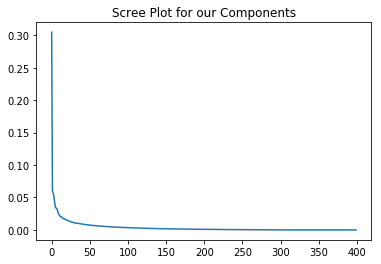

In [83]:
from sklearn.decomposition import PCA


# Scale Data
sklearn_pca = PCA(n_components=400)
pca_feat = X
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(pca_feat)
X_PCA = sklearn_pca.fit_transform(X_normalized)
var_ratios = (list(sklearn_pca.explained_variance_ratio_))
component_variances = (list(sklearn_pca.explained_variance_))
              
# Plotting to decide which features to keep
sorted_eigenvals = sorted(component_variances, reverse=True)
plt.plot(sorted_eigenvals)
plt.title("Scree Plot for our Components")

plt.show()



In [ ]:
plt.show()

print('Percent of variance explained by component \n', var_ratios)
print('\n Eigenvalues: {}'.format(sorted_eigenvals))
chi_selector = SelectKBest(chi2, k=3)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)

In [45]:
# using all of the non job features in a vanilla regression
# I think it's weird to scale after adding square roots to try to normalize
# but not positive
X = df_movies[['budget', 'revenue']]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = df_movies['vote_average']

lr = LinearRegression()

# Cross Validation
print('Negative Mean Square Error: {}'.format(
    cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')))
      
print('R-Squared: {}'.format(
    cross_val_score(lr, X, y, cv=5, scoring='r2'))) 

Negative Mean Square Error: [-1.23350932 -1.3774578  -1.17380291 -1.3537812  -1.14705234]
R-Squared: [0.04851423 0.04602924 0.04959313 0.01653204 0.05979624]


# Try PCA with job vectors

In [20]:
print('y mean: {}, y standard deviation: {}'.format(y.mean(), np.sqrt(np.std(y))))

y mean: 5.6686910994764395, y standard deviation: 1.0762202879145675


In [14]:
feature_columns = df_parsed.department.unique()

X = department_count[feature_columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = job_count['vote_average']
y = y.astype('int')
lr = LinearRegression()

print('Cross Validated R_squared with all jobs:')
print('\n{}'.format(cross_val_score(lr, X, y, cv=5, scoring='r2')))

print('\nCross Validated Neg Mean Squared Error with all jobs:')
print('\n{}'.format(cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')))

print('Cross Validated R_squared with SCALED jobs:')
print('\n{}'.format(cross_val_score(lr, X_scaled, y, cv=5, scoring='r2')))

print('\nCross Validated Neg Mean Squared Error with SCALED jobs:')
print('\n{}'.format(cross_val_score(lr, X_scaled, y, cv=5, scoring='neg_mean_squared_error')))

Cross Validated R_squared with all jobs:

[-0.00408656 -0.00827355 -0.01024601 -0.00134261 -0.00592061]

Cross Validated Neg Mean Squared Error with all jobs:

[-1.4218775  -1.25552485 -1.28997347 -1.25544939 -1.51886099]
Cross Validated R_squared with SCALED jobs:

[-0.00408656 -0.00827355 -0.01024601 -0.00134261 -0.00592061]

Cross Validated Neg Mean Squared Error with SCALED jobs:

[-1.4218775  -1.25552485 -1.28997347 -1.25544939 -1.51886099]


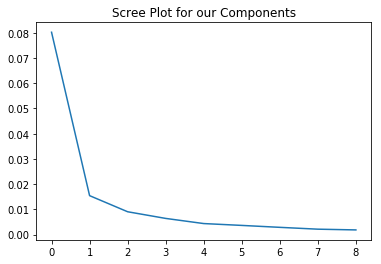

[0.06069282 0.06735651 0.06403205 0.0971853  0.08695474]


Pipeline(memory=None,
     steps=[('scl', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('grid', GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criter...  pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='r2', verbose=0))])

In [32]:


# Scale Data
sklearn_pca = PCA(n_components=9)
pca_feat = X
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(pca_feat)
X_PCA = sklearn_pca.fit_transform(X_normalized)
var_ratios = (list(sklearn_pca.explained_variance_ratio_))
component_variances = (list(sklearn_pca.explained_variance_))
              
# Plotting to decide which features to keep
sorted_eigenvals = sorted(component_variances, reverse=True)
plt.plot(sorted_eigenvals)
plt.title("Scree Plot for our Components")
plt.show()

lr = LinearRegression()

print(cross_val_score(lr, X_PCA, y, cv=5, scoring='r2'))
forest = Pipeline(steps=[('scl', MinMaxScaler()), 
                         ('pca', PCA(n_components=4)),
                         ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 170, 10), # 1- 200
                                                           'max_depth': np.arange(4, 8, 1)}, 
                                               cv=3,
                                               scoring='r2',
                                               refit=False))])
forest.fit(X,y)

In [ ]:
# using all of the non job features in a vanilla regression
# I think it's weird to scale after adding square roots to try to normalize
# but not positive
X = job_count[feature_columns]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = job_count['vote_average']
y = y.astype('int')
lr = LinearRegression()

X = df_movies[['budget', 'revenue', 'popularity', 'vote_count',
              'total_crew']]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = df_movies['vote_average']

lr = LinearRegression()

# Cross Validation
print('Negative Mean Square Error: {}'.format(
    cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')))
      
print('R-Squared: {}'.format(
    cross_val_score(lr, X, y, cv=5, scoring='r2'))) 

In [34]:
feature_columns = df_parsed.job.unique()

X = job_count[feature_columns]
y = job_count['vote_average']

lr = LinearRegression()

cross_val_score(lr, X, y, cv=5,)

array([-0.20844303, -1.78651739, -0.33245533, -0.01156281, -0.05211257])

In [68]:
job_count.columns

Index(['title', 'release_date', 'budget', 'revenue', 'popularity',
       'vote_average', 'vote_count', 'random_number', 'total_crew',
       'budget_sqrt',
       ...
       'Visual Effects Designer', 'Visual Effects Editor',
       'Visual Effects Producer', 'Visual Effects Supervisor',
       'Visual Effects Technical Director', 'Vocal Coach',
       'Wardrobe Supervisor', 'Wig Designer', 'Wigmaker', 'Writer'],
      dtype='object', length=431)

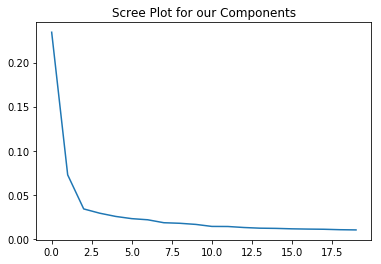

Percent of variance explained by component 
 [0.18066349219854774, 0.05598250306797359, 0.026209249193041854, 0.022468669270781946, 0.019640623778825403, 0.01771364736869863, 0.016715939869999585, 0.014151919278903927, 0.013657085015163165, 0.012672317304877008, 0.010916315719277914, 0.010846254253932383, 0.009965565079122758, 0.009378600941568241, 0.009197304758873481, 0.00881023304663716, 0.008582403770783216, 0.008432411251385469, 0.008041314421559103, 0.007858922810221007]

 Eigenvalues: [0.23436054078596813, 0.07262169868355879, 0.03399919784416114, 0.029146837675729648, 0.025478236660678628, 0.022978521704085174, 0.02168427422721058, 0.018358171952739175, 0.017716262376883854, 0.01643880066991327, 0.014160877907467471, 0.014069992678211574, 0.012927543870425322, 0.012166121454500429, 0.011930940174089438, 0.011428822481695003, 0.011133277478959607, 0.010938703979177627, 0.010431364818274806, 0.010194762524430937]
9 selected features
['Editor', 'Production Design', 'Sound Designer

In [65]:
from sklearn.decomposition import PCA

X = job_count[feature_columns]
y = df_movies['vote_average']
y = y.astype('int')

lr = LinearRegression()

# Scale Data
sklearn_pca = PCA(n_components=20)
pca_feat = X
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(pca_feat)
X_PCA = sklearn_pca.fit_transform(X_normalized)
var_ratios = (list(sklearn_pca.explained_variance_ratio_))
component_variances = (list(sklearn_pca.explained_variance_))
              
# Plotting to decide which features to keep
sorted_eigenvals = sorted(component_variances, reverse=True)
plt.plot(sorted_eigenvals)
plt.title("Scree Plot for our Components")

plt.show()

print('Percent of variance explained by component \n', var_ratios)
print('\n Eigenvalues: {}'.format(sorted_eigenvals))
chi_selector = SelectKBest(chi2, k='all')
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)